<a href="https://colab.research.google.com/github/AnirbanMukherjeeXD/human-activity-recognition/blob/master/HAR_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle API dataset

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d erenaktas/human-activity-recognition --unzip

 99% 118M/119M [00:01<00:00, 41.4MB/s] 
100% 119M/119M [00:01<00:00, 75.0MB/s]


## Importing libraries

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from numpy import dstack
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,SimpleRNN, GRU, LSTM
from tensorflow import feature_column
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

## Dataset Loading

In [0]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	print("Loading: ",filepath)
	return dataframe.values

In [0]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [0]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [0]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'UCI_HAR_Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'UCI_HAR_Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [0]:
X_train, Y_train, X_test, Y_test = load_dataset()

Loading:  UCI_HAR_Dataset/train/Inertial Signals/total_acc_x_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/total_acc_y_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/total_acc_z_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_acc_y_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_acc_z_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_gyro_x_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_gyro_y_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_gyro_z_train.txt
Loading:  UCI_HAR_Dataset/train/y_train.txt
(7352, 128, 9) (7352, 1)
Loading:  UCI_HAR_Dataset/test/Inertial Signals/total_acc_x_test.txt
Loading:  UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt
Loading:  UCI_HAR_Dataset/test/Inertial Signals/total_acc_z_test.txt
Loading:  UCI_HAR_Dataset/test/Inertial Signals/body_acc_x_test.txt
Loading:  UCI_HAR_Da

In [0]:
X_train.shape

(7352, 128, 9)

In [0]:
Y_train.shape

(7352, 6)

In [0]:
X_train[0,:,0].shape

(128,)

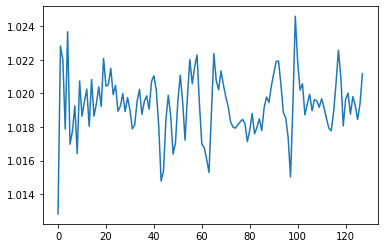

In [0]:
plt.plot(X_train[0,:,0])

## Model 1: GRU

In [0]:
verbose, epochs, batch_size = 2, 10, 32

In [0]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [0]:
print(n_timesteps, n_features, n_outputs)

128 9 6


In [0]:
model = Sequential()
model.add(GRU(100,return_sequences=True,input_shape=(n_timesteps,n_features)))
model.add(GRU(64))
model.add(Dropout(0.15))
model.add(Dense(64, activation='tanh'))
model.add(Dense(n_outputs, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128, 100)          33300     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                31872     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 69,722
Trainable params: 69,722
Non-trainable params: 0
_________________________________________________________________


In [0]:
simple_rnn_params=model.count_params()

In [0]:
history=model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=verbose)

Epoch 1/100
230/230 - 3s - loss: 0.9841 - accuracy: 0.5816
Epoch 2/100
230/230 - 2s - loss: 0.2566 - accuracy: 0.9075
Epoch 3/100
230/230 - 3s - loss: 0.1519 - accuracy: 0.9392
Epoch 4/100
230/230 - 3s - loss: 0.1379 - accuracy: 0.9442
Epoch 5/100
230/230 - 2s - loss: 0.1427 - accuracy: 0.9423
Epoch 6/100
230/230 - 3s - loss: 0.1420 - accuracy: 0.9418
Epoch 7/100
230/230 - 2s - loss: 0.1343 - accuracy: 0.9440
Epoch 8/100
230/230 - 3s - loss: 0.1208 - accuracy: 0.9506
Epoch 9/100
230/230 - 2s - loss: 0.1186 - accuracy: 0.9497
Epoch 10/100
230/230 - 3s - loss: 0.1161 - accuracy: 0.9514
Epoch 11/100
230/230 - 2s - loss: 0.1158 - accuracy: 0.9484
Epoch 12/100
230/230 - 2s - loss: 0.1127 - accuracy: 0.9524
Epoch 13/100
230/230 - 3s - loss: 0.1101 - accuracy: 0.9532
Epoch 14/100
230/230 - 2s - loss: 0.1752 - accuracy: 0.9381
Epoch 15/100
230/230 - 2s - loss: 0.1181 - accuracy: 0.9518
Epoch 16/100
230/230 - 2s - loss: 0.1167 - accuracy: 0.9518
Epoch 17/100
230/230 - 3s - loss: 0.1174 - accura

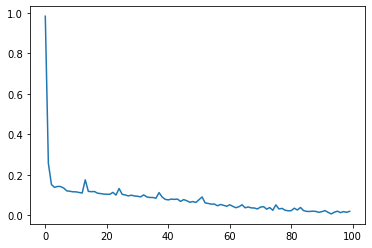

In [0]:
plt.plot(history.history['loss'])

In [0]:
gru_acc_train=model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=0)[1]
gru_acc_test=model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)[1]
print("Training set: ",gru_acc_train*100,"%")
print("Test set: ",gru_acc_test*100,"%")

Training set:  99.7823715209961 %
Test set:  94.09568905830383 %


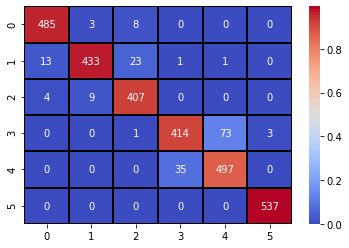

In [0]:
Y_pred=model.predict(X_test)
cm=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
sns.heatmap(cm/cm.sum(axis=0),cmap='coolwarm',annot=cm,fmt='g',linewidths=1, linecolor='black')

In [0]:
model.save('gru.h5')

## Model 2: LSTM

In [0]:
verbose, epochs, batch_size = 2, 10, 32

In [0]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [0]:
print(n_timesteps, n_features, n_outputs)

128 9 6


In [0]:
model = Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(n_timesteps,n_features)))
model.add(LSTM(64))
model.add(Dropout(0.15))
model.add(Dense(64, activation='tanh'))
model.add(Dense(n_outputs, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 100)          44000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 90,790
Trainable params: 90,790
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_params=model.count_params()

In [0]:
history=model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=verbose)

Epoch 1/100
230/230 - 3s - loss: 0.9328 - accuracy: 0.5947
Epoch 2/100
230/230 - 3s - loss: 0.6753 - accuracy: 0.7087
Epoch 3/100
230/230 - 3s - loss: 0.5381 - accuracy: 0.7704
Epoch 4/100
230/230 - 3s - loss: 0.3660 - accuracy: 0.8757
Epoch 5/100
230/230 - 3s - loss: 0.2658 - accuracy: 0.9082
Epoch 6/100
230/230 - 3s - loss: 0.1866 - accuracy: 0.9332
Epoch 7/100
230/230 - 3s - loss: 0.1761 - accuracy: 0.9343
Epoch 8/100
230/230 - 3s - loss: 0.1427 - accuracy: 0.9464
Epoch 9/100
230/230 - 3s - loss: 0.1954 - accuracy: 0.9293
Epoch 10/100
230/230 - 3s - loss: 0.2580 - accuracy: 0.9150
Epoch 11/100
230/230 - 3s - loss: 0.1546 - accuracy: 0.9464
Epoch 12/100
230/230 - 3s - loss: 0.1305 - accuracy: 0.9493
Epoch 13/100
230/230 - 3s - loss: 0.1266 - accuracy: 0.9468
Epoch 14/100
230/230 - 3s - loss: 0.1275 - accuracy: 0.9461
Epoch 15/100
230/230 - 3s - loss: 0.1189 - accuracy: 0.9498
Epoch 16/100
230/230 - 3s - loss: 0.1156 - accuracy: 0.9520
Epoch 17/100
230/230 - 3s - loss: 0.1230 - accura

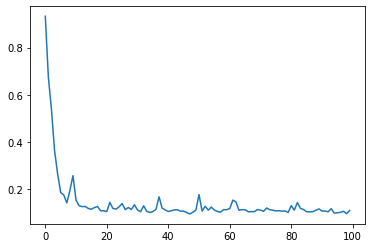

In [0]:
plt.plot(history.history['loss'])

In [0]:
lstm_acc_train=model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=0)[1]
lstm_acc_test=model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)[1]

print("Training set: ",lstm_acc_train*100,"%")
print("Test set: ",lstm_acc_test*100,"%")

Training set:  94.88574266433716 %
Test set:  90.7024085521698 %


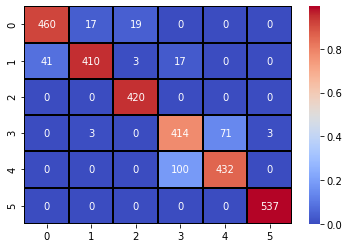

In [0]:
Y_pred=model.predict(X_test)
cm=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
sns.heatmap(cm/cm.sum(axis=0),cmap='coolwarm',annot=cm,fmt='g',linewidths=1, linecolor='black')

In [0]:
model.save('lstm.h5')